# Artificial Intelligence (CS6364-002) 
## Homework 3 - Question 1
## Submission by - Adithya Sundararajan Iyer (asi200000)


(Regression) Implement a neural network to train a regression model for the Boston housing data set

You have to use PyTorch deep learning library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tqdm
import pandas as pd  
import seaborn as sns 

In [2]:
from sklearn.datasets import load_boston

bostonHousingDataset = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

To have a look at the dataset loaded, we look at its keys

In [3]:
datasetKeys = bostonHousingDataset.keys()
print(datasetKeys)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])


Now we need to read the description to get a better understanding of the dataset

In [4]:
print(bostonHousingDataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Split the dataset to a training set (70% samples) and a testing set (30% samples)

In [5]:
from sklearn.model_selection import train_test_split

x, y = bostonHousingDataset.data, bostonHousingDataset.target
xData = x.astype(np.float32)
yData = y.astype(np.float32)
xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, test_size=0.3, random_state=42)
numFeats = xData.shape[1]
print(xTrain.shape, xTest.shape)
print(yTrain.shape, yTest.shape)
print('Num of features:', numFeats)

(354, 13) (152, 13)
(354,) (152,)
Num of features: 13


Data Analysis

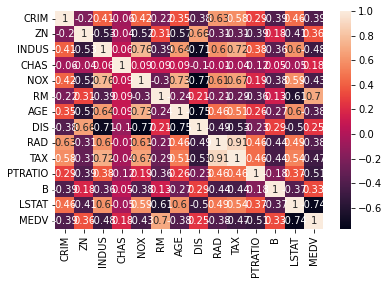

In [6]:
columns = list(bostonHousingDataset.feature_names)
columns.append('MEDV')
bostonDataframe = pd.DataFrame(np.hstack([xData, np.atleast_2d(yData).T]), columns=columns)
corrMat = bostonDataframe.corr().round(2)
sns.heatmap(corrMat, annot=True)

Now we create a DataMaker for our dataset

In [7]:
import torch.utils.data as TorchData
from sklearn.preprocessing import MinMaxScaler

class BostonDataMaker(TorchData.Dataset):

  def __init__(self, x, y):
    mmScaler = MinMaxScaler()
    self.trgts = mmScaler.fit_transform(x.astype(np.float32))
    self.lbls = y.astype(np.float32)
  
  def __getitem__(self, index):
    return self.trgts[index, :], self.lbls[index]
  
  def __len__(self):
    return len(self.trgts)


Now we use PyTorch to create the Neural Network Model

In [8]:
import torch
from torch import nn, optim
from torch.nn import functional as Func

class NNModel(nn.Module):

  def __init__(self, numFeat, hidden1, hidden2):
    super(NNModel, self).__init__()
    self.linear1 = nn.Linear(numFeat, hidden1)
    self.linear2 = nn.Linear(hidden1, hidden2)
    self.linear3 = nn.Linear(hidden2, 1)
  
  def forward(self, x):
    h1 = Func.relu(self.linear1(x))
    h2 = Func.tanh(self.linear2(h1))
    op = self.linear3(h2)
    return op

torch.manual_seed(1)

In [9]:
trainSet = BostonDataMaker(xTrain, yTrain)
testSet = BostonDataMaker(xTest, yTest)

trainLoad = TorchData.DataLoader(trainSet, batch_size=25, shuffle=True)
testLoad = TorchData.DataLoader(testSet, batch_size=25, shuffle=True)

NeuralNet = NNModel(numFeats, 16, 32)

criterion = nn.MSELoss(size_average=False)
optimize = optim.Adam(NeuralNet.parameters(), lr=0.005)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Now we perform the training

In [10]:
epochs = 50
lossList = list()
for epch in range(1, epochs+1):
  progBar = tqdm.notebook.tqdm(trainLoad, leave=False)
  losses = []
  cnt = 0
  for ip,op in progBar:
    optimize.zero_grad()
    yPred = NeuralNet(ip)
    loss = criterion(yPred, torch.unsqueeze(op, dim=1))
    loss.backward()
    optimize.step()
    progBar.set_description(f'Loss = {loss.item():.3f}')
    losses.append(loss.item())
    cnt += 1
  epochLoss = sum(losses)/cnt
  lossList.append(epochLoss)
  print('Epoch', epch, '\t Loss = ', epochLoss)


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1 	 Loss =  13835.440197753906


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 	 Loss =  11265.383626302084


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 	 Loss =  8305.273767089844


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4 	 Loss =  6194.38271484375


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 	 Loss =  4760.663532002767


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6 	 Loss =  3763.192374674479


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7 	 Loss =  3131.3427271525065


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8 	 Loss =  2700.716092936198


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9 	 Loss =  2434.6281901041666


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10 	 Loss =  2281.6505900065104


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11 	 Loss =  2182.996545410156


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12 	 Loss =  2137.3031331380207


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13 	 Loss =  2104.5595703125


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14 	 Loss =  2089.991707356771


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15 	 Loss =  2082.614923095703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16 	 Loss =  2078.7644205729166


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17 	 Loss =  2076.9033325195314


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18 	 Loss =  2076.6936818440754


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19 	 Loss =  2076.0393107096356


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20 	 Loss =  2075.920556640625


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21 	 Loss =  2075.4062235514325


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22 	 Loss =  2076.087674967448


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23 	 Loss =  2075.3471262613934


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24 	 Loss =  2075.3502685546873


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25 	 Loss =  2076.0375813802084


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26 	 Loss =  2075.5981648763022


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27 	 Loss =  2075.2648969014485


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28 	 Loss =  2075.2572509765623


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29 	 Loss =  2075.342194620768


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30 	 Loss =  2075.157291666667


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31 	 Loss =  2075.4003702799478


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 32 	 Loss =  2077.067957560221


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33 	 Loss =  2075.9258003234863


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 34 	 Loss =  2077.906620279948


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 35 	 Loss =  2078.4605346679687


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36 	 Loss =  2080.5046010335286


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 37 	 Loss =  2075.0982228597004


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 38 	 Loss =  2076.192374674479


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39 	 Loss =  2075.0631571451822


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 40 	 Loss =  2075.7627766927085


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 41 	 Loss =  2075.166289774577


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 42 	 Loss =  2077.789373779297


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 43 	 Loss =  2075.035721842448


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 44 	 Loss =  2075.8713948567706


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 45 	 Loss =  2075.375909423828


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 46 	 Loss =  2075.1140096028644


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 47 	 Loss =  2075.6804260253907


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 48 	 Loss =  2076.929791259766


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 49 	 Loss =  2076.260949707031


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 50 	 Loss =  2075.768505859375


Let's visualize the variation of these losses with the epochs

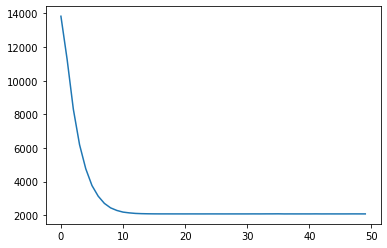

In [11]:
plt.plot(lossList)

Now we proceed to Testing of the Neural Net Model

In [14]:
yTrue = list()
yPred = list()
NeuralNet.train(False)
for ip,op in testLoad:
  yPred.extend(NeuralNet(ip).data.numpy())
  yTrue.extend(op.numpy())


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Now we print the root mean squared errors (RMSE) on the testing dataset in the Jupyter notebook.

In [15]:
from sklearn.metrics import mean_squared_error

rmseTest = np.sqrt(mean_squared_error(yTrue, yPred))
print('Test performance of model: RMSE =', rmseTest)

Test performance of model: RMSE = 8.780571
